In [1]:
import xarray as xr
import numpy as np

# Load saved results

In [2]:
datasets = {'RAS':'RAS_n1000_2Hz.nc',
            'RAS_FR':'RAS_n1000_2Hz_fixedres.nc',
            'DAS':'DAS_n1000_2Hz.nc',
            'DAS_FR':'DAS_n1000_2Hz_fixedres.nc'}

dsets = [xr.open_dataset(f'data/timeseries_stats/{fn}') for fn in datasets.values()]
ds = xr.concat(dsets,dim=xr.DataArray(list(datasets.keys()),dims='mthd'))

ds['HmHs'] = ds['Hmax']/ds['Hs']
ds_std = ds.std(dim='seed')
ds_mean = ds.mean(dim='seed')
ds_max = ds.max(dim='seed')
ds_CV = ds_std/ds_mean
ds_CV

<xarray.Dataset>
Dimensions:           (gamma: 1, tp: 1, duration: 6, mthd: 4)
Coordinates:
    fft_min_duration  int32 3600
  * gamma             (gamma) float64 3.3
  * tp                (tp) float64 12.0
  * duration          (duration) int32 120 300 600 1200 2400 3600
    hs                float64 1.0
    dt                float64 0.5
  * mthd              (mthd) <U6 'RAS' 'RAS_FR' 'DAS' 'DAS_FR'
Data variables: (12/17)
    this_seed         (mthd, tp, gamma, duration) float64 0.5739 ... 0.5964
    Tz                (mthd, tp, gamma, duration) float64 0.1234 ... 0.01817
    Tm01              (mthd, tp, gamma, duration) float64 0.0654 ... 2.057e-14
    Hm0               (mthd, tp, gamma, duration) float64 0.1884 0.1216 ... 0.0
    Hs                (mthd, tp, gamma, duration) float64 0.1884 ... 3.865e-09
    H13               (mthd, tp, gamma, duration) float64 0.1998 ... 0.007839
    ...                ...
    r_spectra         (mthd, tp, gamma, duration) float64 0.09534 ... 1.211e-14
    r_sample          (mthd, tp, gamma, duration) float64 0.4342 ... 0.06041
    r_unbiased        (mthd, tp, gamma, duration) float64 0.6249 ... 0.06129
    k3                (mthd, tp, gamma, duration) float64 -60.02 50.79 ... 41.98
    k4                (mthd, tp, gamma, duration) float64 -1.429 ... -11.28
    HmHs              (mthd, tp, gamma, duration) float64 0.1201 ... 0.08443

## Examine distribution of parameters averaged across Tp and Gamma

In [3]:
import seaborn as sns
from scipy.stats.distributions import norm
import matplotlib.pyplot as plt

In [4]:
ds_stacked = ds.isel(seed=slice(0,1000)).stack(sample=['tp','gamma','seed'])
ds_stacked

<xarray.Dataset>
Dimensions:           (duration: 6, mthd: 4, sample: 1000)
Coordinates:
    fft_min_duration  int32 3600
  * duration          (duration) int32 120 300 600 1200 2400 3600
    hs                float64 1.0
    dt                float64 0.5
  * mthd              (mthd) <U6 'RAS' 'RAS_FR' 'DAS' 'DAS_FR'
  * sample            (sample) MultiIndex
  - tp                (sample) float64 12.0 12.0 12.0 12.0 ... 12.0 12.0 12.0
  - gamma             (sample) float64 3.3 3.3 3.3 3.3 3.3 ... 3.3 3.3 3.3 3.3
  - seed              (sample) int64 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
Data variables: (12/17)
    this_seed         (mthd, duration, sample) int32 792397573 ... 847640783
    Tz                (mthd, duration, sample) float64 10.55 9.76 ... 9.37 9.465
    Tm01              (mthd, duration, sample) float64 10.36 9.541 ... 10.02
    Hm0               (mthd, duration, sample) float64 0.9482 0.8075 ... 1.0 1.0
    Hs                (mthd, duration, sample) float64 0.9482 0.8075 ... 1.0 1.0
    H13               (mthd, duration, sample) float64 0.9546 0.7491 ... 0.967
    ...                ...
    r_spectra         (mthd, duration, sample) float64 0.7522 0.7352 ... 0.7515
    r_sample          (mthd, duration, sample) float64 0.8109 0.5177 ... 0.6147
    r_unbiased        (mthd, duration, sample) float64 0.7488 0.4439 ... 0.6072
    k3                (mthd, duration, sample) float64 -0.1859 ... -0.04875
    k4                (mthd, duration, sample) float64 -0.5679 ... 0.002428
    HmHs              (mthd, duration, sample) float64 1.081 1.017 ... 1.566

In [5]:
import warnings
warnings.filterwarnings('ignore')

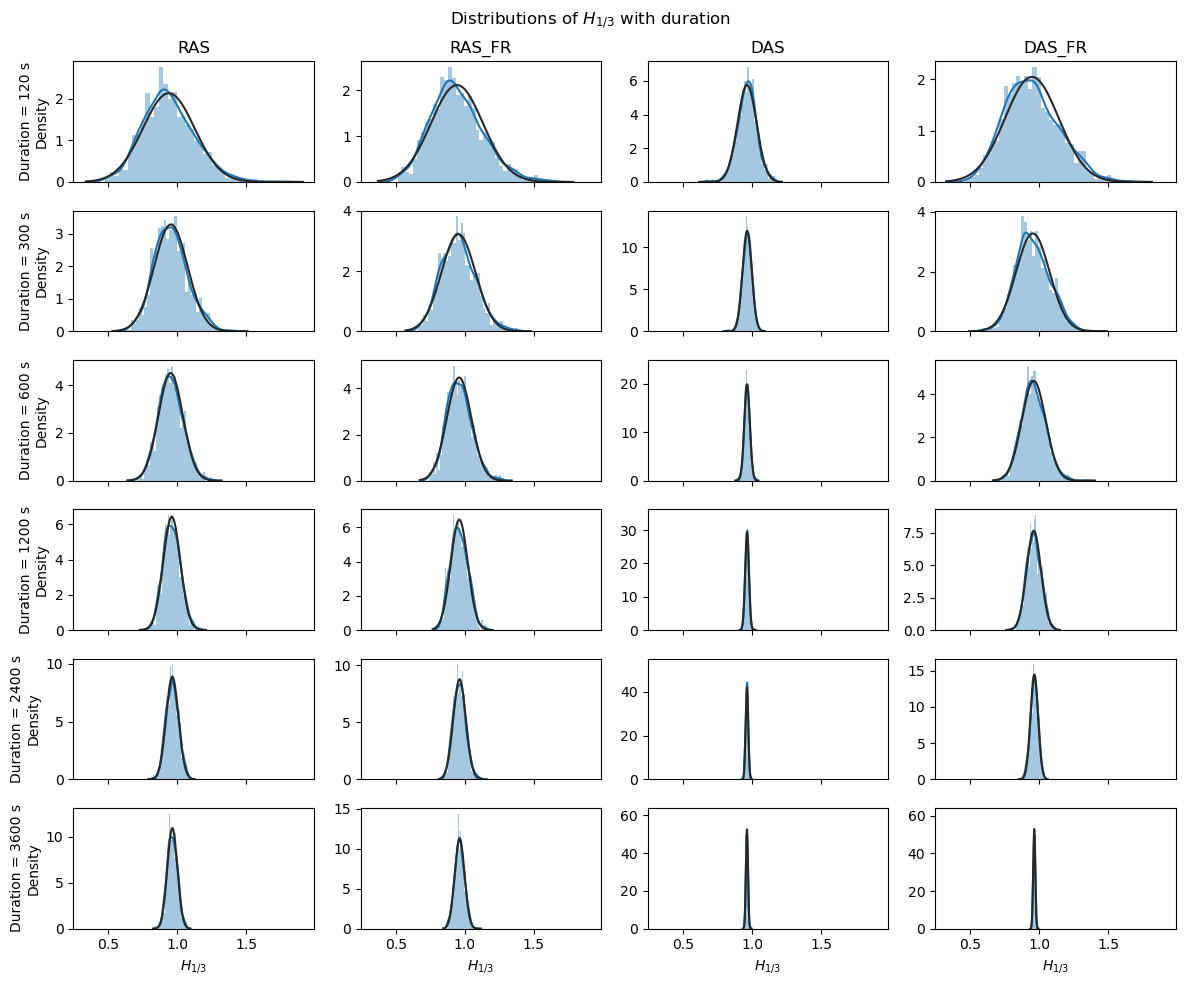

In [6]:
def distplot(ds_stacked,v,label):
    fig,axs = plt.subplots(len(ds_stacked.duration),len(ds_stacked.mthd),figsize=(12,10),sharex=True)
    for i,d in enumerate(ds_stacked.duration):
        for j,m in enumerate(ds_stacked.mthd):
            m = m.values
            ax = axs[i,j]
            data = ds_stacked[v].sel(duration=d,mthd=m)
            sns.distplot(data,ax = ax,fit=norm,hist=True,bins=40)
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.set_title('')

    for j,m in enumerate(ds_stacked.mthd):
        axs[0,j].set_title(f'{m.values}')     
        axs[-1,j].set_xlabel(f'${label}$')   
    for i,d in enumerate(ds_stacked.duration):
        axs[i,0].set_ylabel(f'Duration = {d.values} s\nDensity')


    fig.suptitle(f'Distributions of ${label}$ with duration')
    fig.tight_layout()
    return fig,axs
    
fig,axs = distplot(ds_stacked,'H13','H_{1/3}')

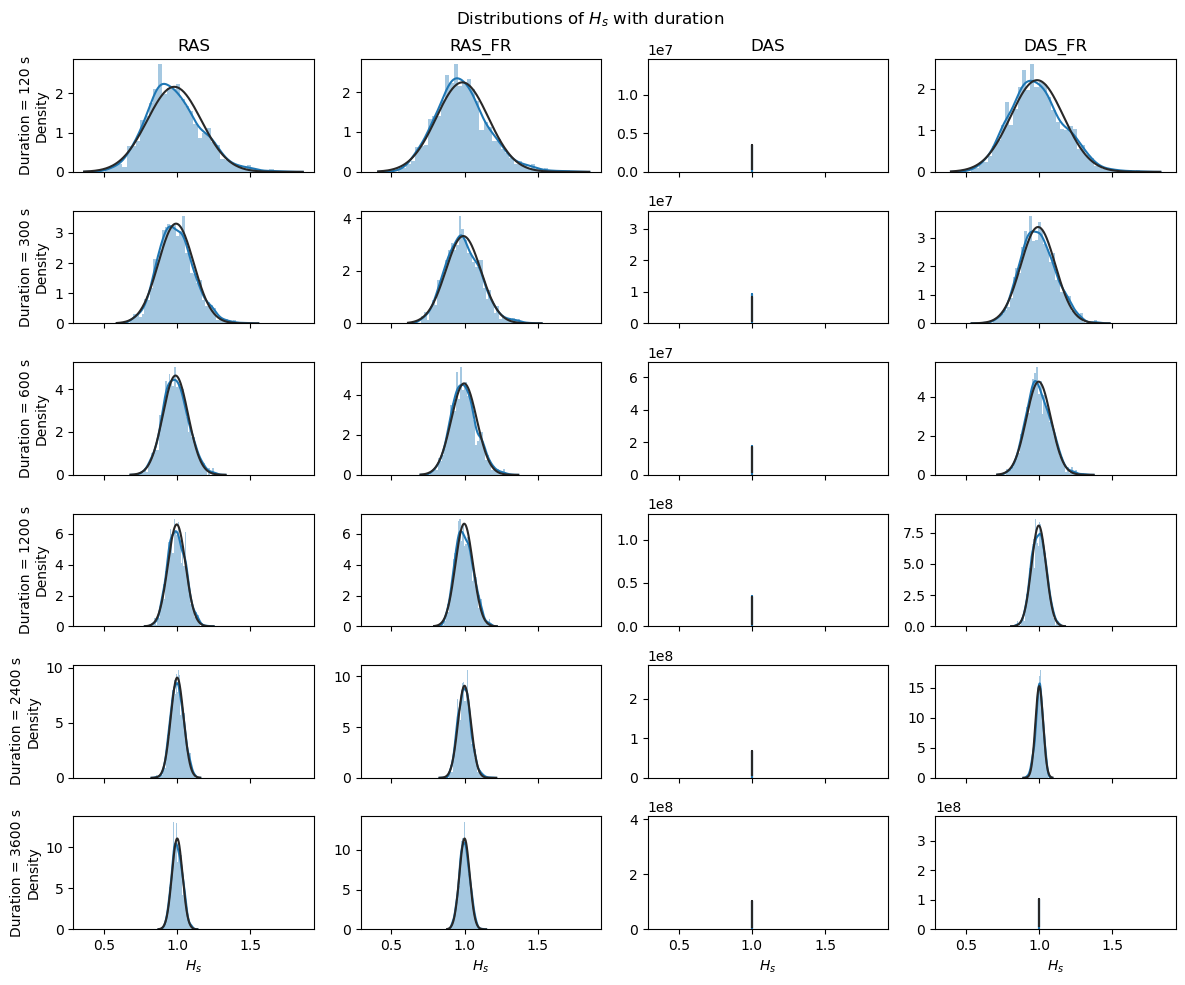

In [7]:
fig, axs = distplot(ds_stacked,'Hs','H_s')

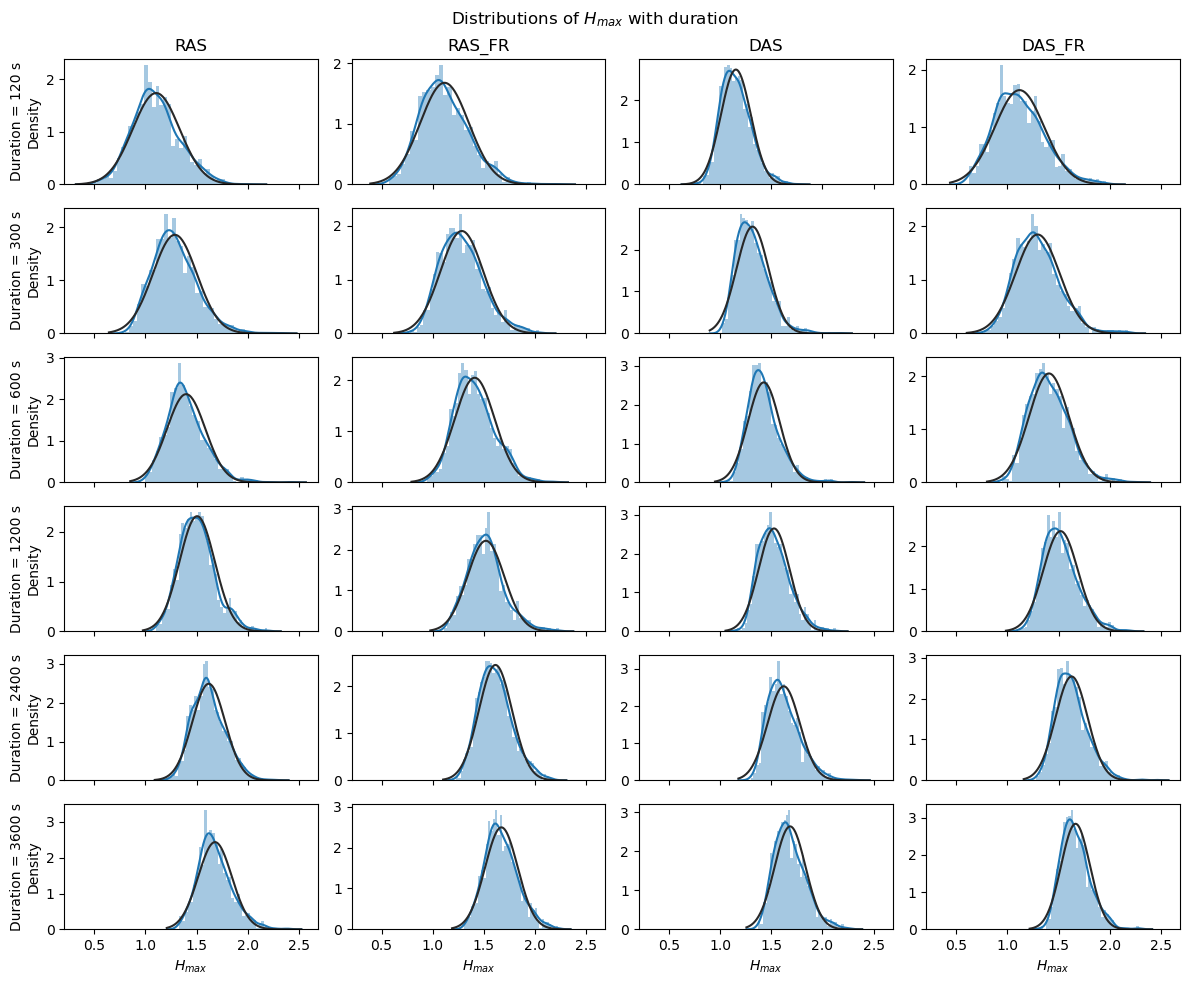

In [8]:
fig, axs = distplot(ds_stacked,'Hmax','H_{max}')

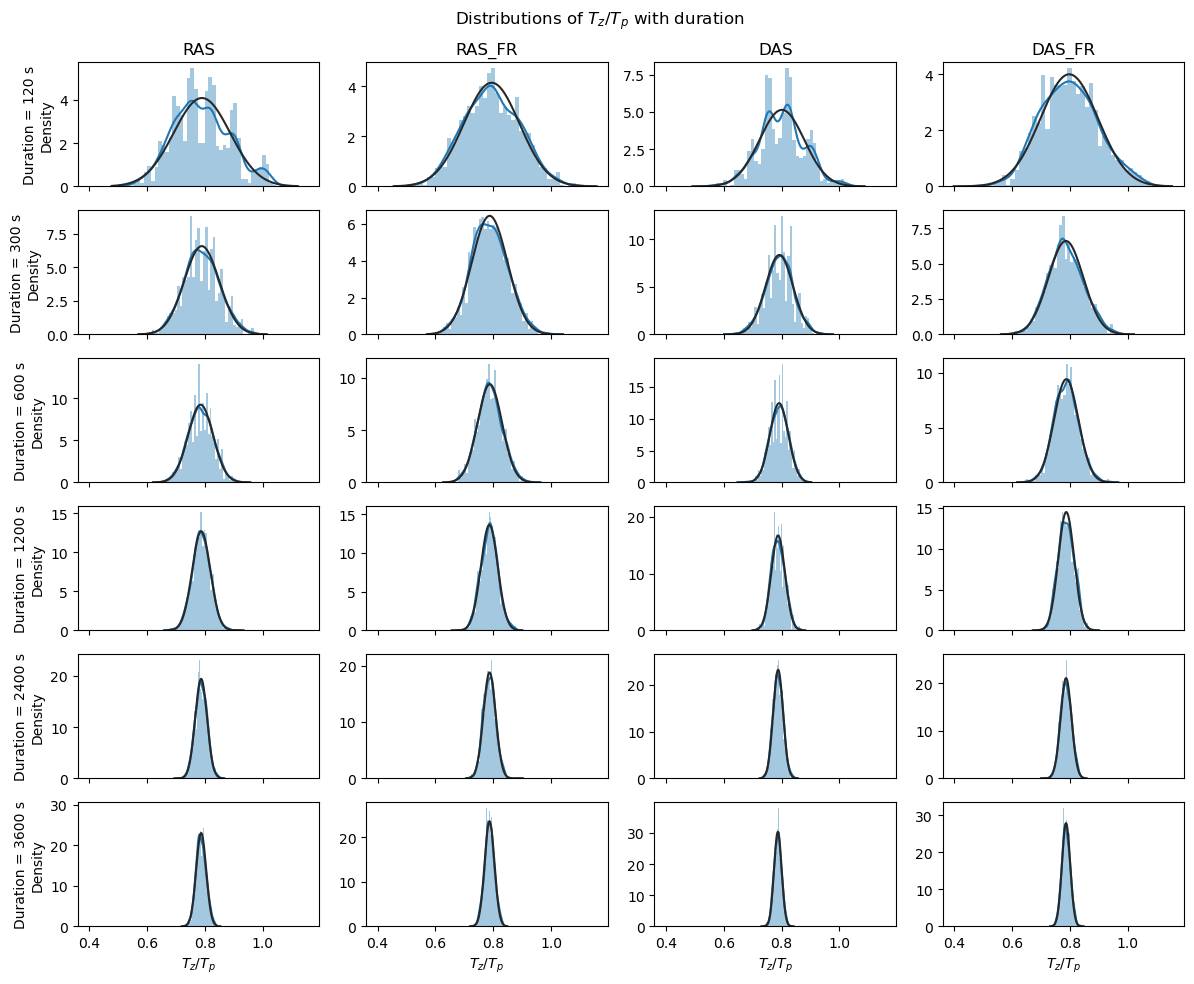

In [9]:
ds_stacked['TzTp'] = ds_stacked.Tz/ds_stacked.tp
fig, axs = distplot(ds_stacked,'TzTp','T_z/T_p')

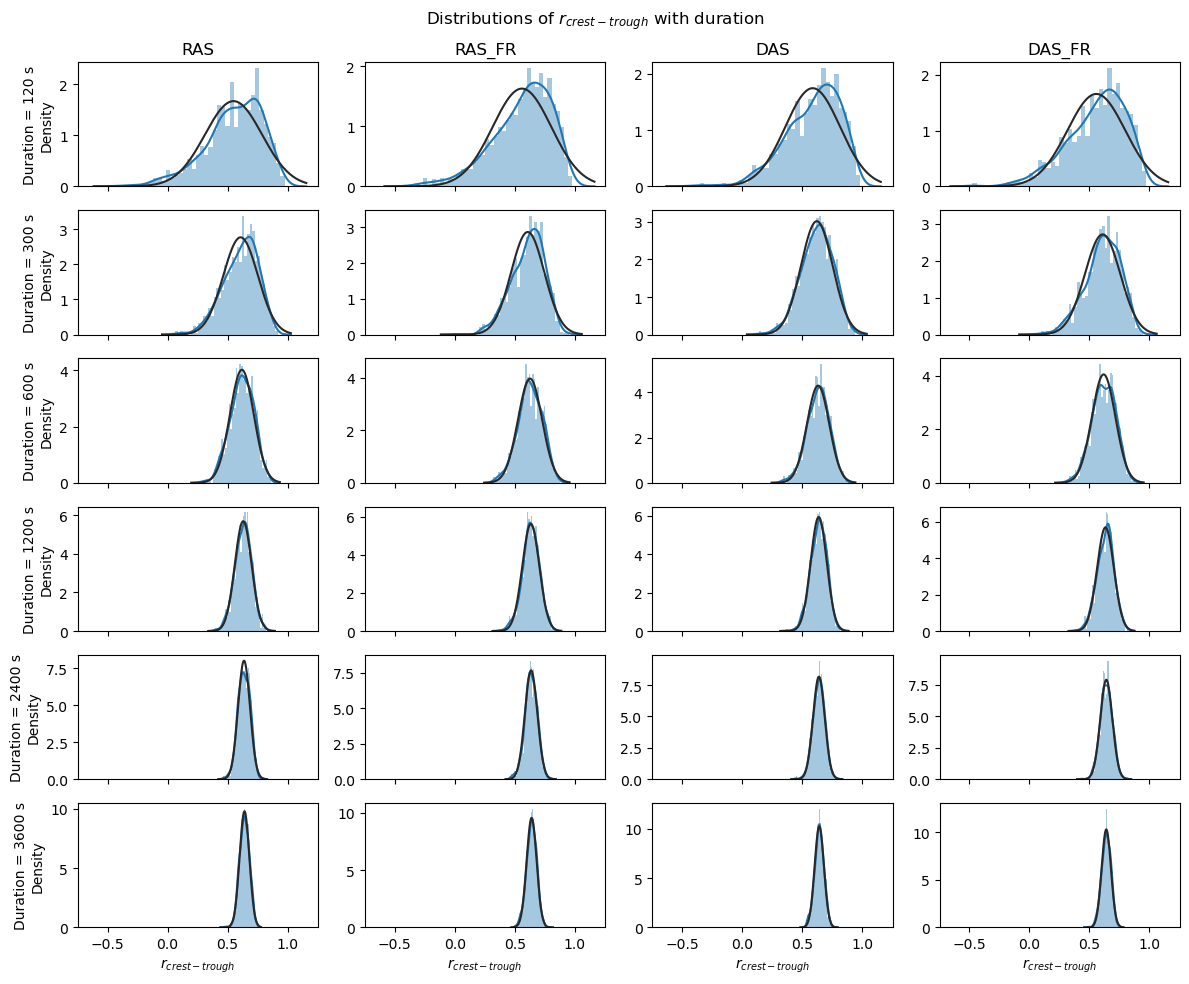

In [10]:
fig, axs = distplot(ds_stacked,'r_sample','r_{crest-trough}')

In [11]:
ds_results_mean = ds.stack(sample=['tp','gamma','seed']).mean(dim='sample')
ds_results_std = ds.stack(sample=['tp','gamma','seed']).std(dim='sample')
ds_results = ds_results_std/ds_results_mean
ds_results = ds_results.drop('this_seed')
ds_results

<xarray.Dataset>
Dimensions:           (duration: 6, mthd: 4)
Coordinates:
    fft_min_duration  int32 3600
  * duration          (duration) int32 120 300 600 1200 2400 3600
    hs                float64 1.0
    dt                float64 0.5
  * mthd              (mthd) <U6 'RAS' 'RAS_FR' 'DAS' 'DAS_FR'
Data variables: (12/16)
    Tz                (mthd, duration) float64 0.1234 0.07665 ... 0.01817
    Tm01              (mthd, duration) float64 0.0654 0.04294 ... 2.057e-14
    Hm0               (mthd, duration) float64 0.1884 0.1216 0.08722 ... 0.0 0.0
    Hs                (mthd, duration) float64 0.1884 0.1216 ... 3.865e-09
    H13               (mthd, duration) float64 0.1998 0.1277 ... 0.007839
    H13_unbiased      (mthd, duration) float64 0.2012 0.1264 ... 0.008027
    ...                ...
    r_spectra         (mthd, duration) float64 0.09534 0.06268 ... 1.211e-14
    r_sample          (mthd, duration) float64 0.4342 0.2372 ... 0.0791 0.06041
    r_unbiased        (mthd, duration) float64 0.6249 0.2944 ... 0.0815 0.06129
    k3                (mthd, duration) float64 -60.02 50.79 ... -36.22 41.98
    k4                (mthd, duration) float64 -1.429 -2.426 ... -11.73 -11.28
    HmHs              (mthd, duration) float64 0.1201 0.1154 ... 0.09222 0.08443

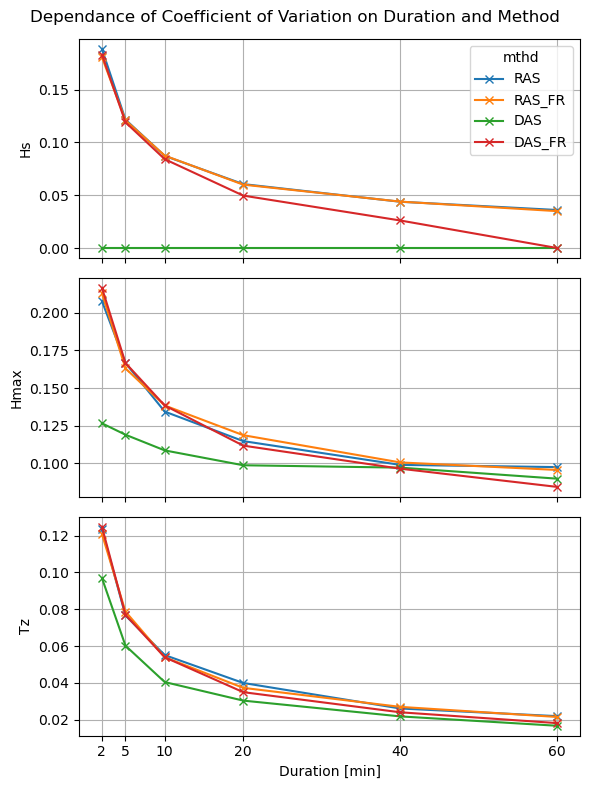

In [12]:
ds_subset = ds_results[['Hs','Hmax','Tz']]
ds_subset['duration'] = ds_subset['duration']/60

fig,axs = plt.subplots(3,1,sharex=True,figsize=(6,8))
axs = axs.ravel()

for i,v in enumerate(ds_subset.data_vars):
    ax=axs[i]
    ds_subset[v].plot(hue='mthd',ax=ax,marker='x',add_legend=i==0)
    ax.grid('on')
    ax.set_xlabel('')
    ax.set_title('')
    ax.set_xticks(ds_subset['duration'].values)

axs[-1].set_xlabel('Duration [min]')

fig.suptitle('Dependance of Coefficient of Variation on Duration and Method')
fig.tight_layout()
fig.savefig('figures/TimeseriesMethodComparison.png')